In [7]:
from keras.layers import Input, merge, add, Dropout, Dense, Flatten, Activation,Concatenate
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras
#import tensorflowjs as tfjs

from keras import backend as K
from keras.utils.data_utils import get_file

"""
Implementation of Inception Network v4 [Inception Network v4 Paper](http://arxiv.org/pdf/1602.07261v1.pdf) in Keras.
"""

TH_BACKEND_TH_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_th_dim_ordering_th_kernels.h5"
TH_BACKEND_TF_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_tf_dim_ordering_th_kernels.h5"
TF_BACKEND_TF_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_tf_dim_ordering_tf_kernels.h5"
TF_BACKEND_TH_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_th_dim_ordering_tf_kernels.h5"


def conv_block(x, nb_filter, nb_row, nb_col, border_mode='same', subsample=(1, 1), bias=False):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    x = Convolution2D(nb_filter, nb_row, nb_col, subsample=subsample, border_mode=border_mode, bias=bias)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    return x


def inception_stem(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    x = conv_block(input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
    x = conv_block(x, 32, 3, 3, border_mode='valid')
    x = conv_block(x, 64, 3, 3)

    x1 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(x)
    x2 = conv_block(x, 96, 3, 3, subsample=(2, 2), border_mode='valid')

    x = Concatenate([x1, x2], )

    x1 = conv_block(x, 64, 1, 1)
    x1 = conv_block(x1, 96, 3, 3, border_mode='valid')

    x2 = conv_block(x, 64, 1, 1)
    x2 = conv_block(x2, 64, 1, 7)
    x2 = conv_block(x2, 64, 7, 1)
    x2 = conv_block(x2, 96, 3, 3, border_mode='valid')

    x = Concatenate([x1, x2], axis=-1)

    x1 = conv_block(x, 192, 3, 3, subsample=(2, 2), border_mode='valid')
    x2 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(x)

    x = Concatenate([x1, x2])
    return x


def inception_A(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    a1 = conv_block(input, 96, 1, 1)

    a2 = conv_block(input, 64, 1, 1)
    a2 = conv_block(a2, 96, 3, 3)

    a3 = conv_block(input, 64, 1, 1)
    a3 = conv_block(a3, 96, 3, 3)
    a3 = conv_block(a3, 96, 3, 3)

    a4 = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(input)
    a4 = conv_block(a4, 96, 1, 1)

    m = Concatenate([a1, a2, a3, a4],)
    return m


def inception_B(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    b1 = conv_block(input, 384, 1, 1)

    b2 = conv_block(input, 192, 1, 1)
    b2 = conv_block(b2, 224, 1, 7)
    b2 = conv_block(b2, 256, 7, 1)

    b3 = conv_block(input, 192, 1, 1)
    b3 = conv_block(b3, 192, 7, 1)
    b3 = conv_block(b3, 224, 1, 7)
    b3 = conv_block(b3, 224, 7, 1)
    b3 = conv_block(b3, 256, 1, 7)

    b4 = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(input)
    b4 = conv_block(b4, 128, 1, 1)

    m = Concatenate([b1, b2, b3, b4])
    return m


def inception_C(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    c1 = conv_block(input, 256, 1, 1)

    c2 = conv_block(input, 384, 1, 1)
    c2_1 = conv_block(c2, 256, 1, 3)
    c2_2 = conv_block(c2, 256, 3, 1)
    c2 = Concatenate([c2_1, c2_2],)

    c3 = conv_block(input, 384, 1, 1)
    c3 = conv_block(c3, 448, 3, 1)
    c3 = conv_block(c3, 512, 1, 3)
    c3_1 = conv_block(c3, 256, 1, 3)
    c3_2 = conv_block(c3, 256, 3, 1)
    c3 = Concatenate([c3_1, c3_2],)

    c4 = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(input)
    c4 = conv_block(c4, 256, 1, 1)

    m = Concatenate([c1, c2, c3, c4],)
    return m


def reduction_A(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    r1 = conv_block(input, 384, 3, 3, subsample=(2, 2), border_mode='valid')

    r2 = conv_block(input, 192, 1, 1)
    r2 = conv_block(r2, 224, 3, 3)
    r2 = conv_block(r2, 256, 3, 3, subsample=(2, 2), border_mode='valid')

    r3 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(input)

    m = Concatenate([r1, r2, r3],)
    return m


def reduction_B(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    r1 = conv_block(input, 192, 1, 1)
    r1 = conv_block(r1, 192, 3, 3, subsample=(2, 2), border_mode='valid')

    r2 = conv_block(input, 256, 1, 1)
    r2 = conv_block(r2, 256, 1, 7)
    r2 = conv_block(r2, 320, 7, 1)
    r2 = conv_block(r2, 320, 3, 3, subsample=(2, 2), border_mode='valid')

    r3 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(input)

    m = Concatenate([r1, r2, r3],)
    return m


def create_inception_v4(nb_classes=1001, load_weights=True):
#     imodel=keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
#     imodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#     imodel.summary()
# #     tfjs.converters.save_keras_model(imodel, 'InceptionV4')
#     return imodel
    
    if K.image_data_format() == 'th':
        init = Input((3, 299, 299))
    else:
        init = Input((299, 299, 3))

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    x = inception_stem(init)

    # 4 x Inception A
    for i in range(4):
        x = inception_A(x)

    # Reduction A
    x = reduction_A(x)

    # 7 x Inception B
    for i in range(7):
        x = inception_B(x)

    # Reduction B
    x = reduction_B(x)

    # 3 x Inception C
    for i in range(3):
        x = inception_C(x)

    # Average Pooling
    x = AveragePooling2D((8, 8))(x)

    # Dropout
    x = Dropout(0.8)(x)
    x = Flatten()(x)

    # Output
    out = Dense(output_dim=nb_classes, activation='softmax')(x)

    model = Model(init, out, name='Inception-v4')

    if load_weights:
        if K.backend() == "theano":
            if K.image_data_format() == "th":
                weights = get_file('inception_v4_weights_th_dim_ordering_th_kernels.h5', TH_BACKEND_TH_DIM_ORDERING,
                                   cache_subdir='models')
            else:
                weights = get_file('inception_v4_weights_tf_dim_ordering_th_kernels.h5', TH_BACKEND_TF_DIM_ORDERING,
                                   cache_subdir='models')
        else:
            if K.image_data_format() == "th":
                weights = get_file('inception_v4_weights_th_dim_ordering_tf_kernels.h5', TF_BACKEND_TH_DIM_ORDERING,
                                   cache_subdir='models')
            else:
                weights = get_file('inception_v4_weights_tf_dim_ordering_tf_kernels.h5', TF_BACKEND_TF_DIM_ORDERING,
                                   cache_subdir='models')

        model.load_weights("inception_v4_weights_tf_dim_ordering_tf_kernels.h5")
        print("Model weights loaded.")

    return model


# if __name__ == "__main__":
#     # from keras.utils.visualize_util import plot

#     inception_v4 = create_inception_v4(load_weights=True)
#     # inception_v4.summary()

#     # plot(inception_v4, to_file="Inception-v4.png", show_shapes=True)

In [8]:
inception_v4 = create_inception_v4(18,load_weights=False)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [9]:
from keras.preprocessing import image
generator = image.ImageDataGenerator(horizontal_flip=True, rotation_range=10, shear_range=.1)
gen = generator.flow_from_directory("Datasets/dataset/train/", target_size=(224, 224), batch_size=12)

Found 18223 images belonging to 23 classes.


In [10]:
inception_v4.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:

inception_v4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# inception_v4.fit_generator(gen,nb_epoch=10,samples_per_epoch=900)

In [14]:
# import keras
# from keras.layers import Input, merge, add, Dropout, Dense, Flatten, Activation,Concatenate
# from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
# from keras.layers.normalization import BatchNormalization
# from keras.models import Model

In [15]:
# imodel=keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
# # flat = Flatten()(imodel.output)
# # d1 = Dense(1000, activation="relu") (flat)
# # dp1 = Dropout(rate=.15)(d1)
# # d2 = Dense(500, activation="relu") (dp1)
# # d3 = Dense(250, activation="relu") (d2)
# # dp2 = Dropout(rate=.15)(d3)
# # out = Dense(23, activation="softmax") (dp2)

# # model = Model(inputs=[resnet_mod.input], outputs=[out])
# imodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# imodel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

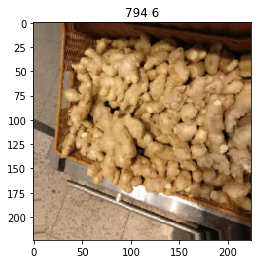

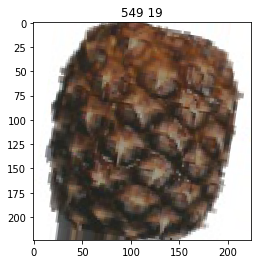

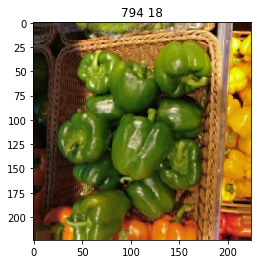

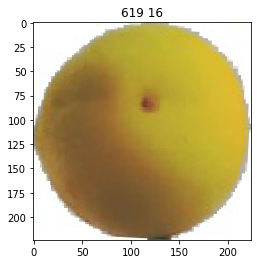

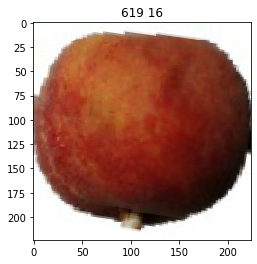

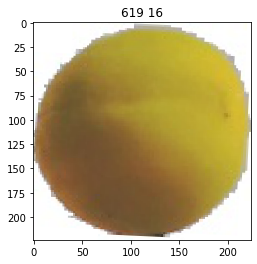

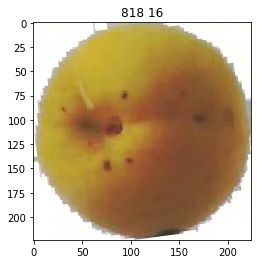

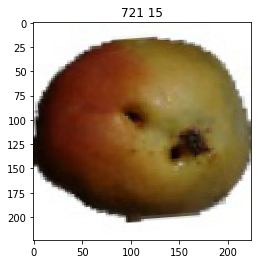

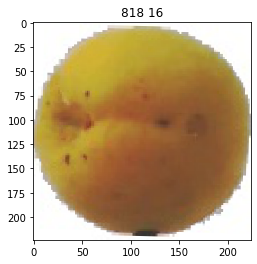

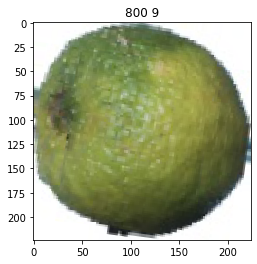

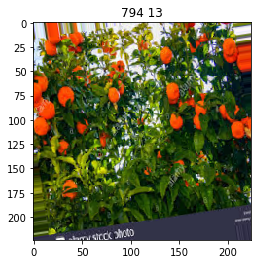

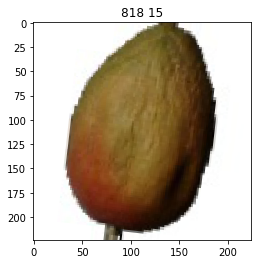

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# # imodel.predict_generator(gen)
# images, vals = gen.next()
# evals = imodel.predict(images)
# res = np.argmax(evals, axis=1)
# for img, ev, va in zip(images, res,vals):
#     plt.figure()
#     plt.title(str(ev)+" "+ str(np.argmax(va)))
#     plt.imshow(img/255)